<a href="https://colab.research.google.com/github/kathrynberger/tensorflow-eo-training/blob/kathryn-pytorch-1/ds_book/docs/Kathryn_Planet_NICFI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Access and mosaic Planet NICFI monthly basemaps

> A guide for accessing monthly Planet NICFI basemaps, selecting data by a defined AOI and mosaicing to produce a single image. 

You will need a configuration file named `planet_api.cfg` (simple text file with `.cfg` extension will do) to run this notebook. It should be located in your `My Drive` folder.

The contents of the file should reflect the template below, swapping in the API access key that you should have receieved once you signed up for and subscribed to the Planet NICFI program. Please visit https://www.planet.com/nicfi/ to sign up if you have not already. 



```
[credentials]
api_key = xxxxxxxxxxxxxxxxx
```






## Setup Notebook

```{admonition} **Version control**
Colab updates without warning to users, which can cause notebooks to break. Therefore, we are pinning library versions.
``` 

In [1]:
!pip install -q rasterio==1.2.10
!pip install -q geopandas==0.10.2
!pip install -q shapely==1.8.0
!pip install -q radiant_mlhub # for dataset access, see: https://mlhub.earth/

     |████████████████████████████████| 19.3 MB 59.2 MB/s 
     |████████████████████████████████| 1.0 MB 32.8 MB/s 
     |████████████████████████████████| 6.3 MB 38.9 MB/s 
     |████████████████████████████████| 15.4 MB 50.5 MB/s 
     |████████████████████████████████| 133 kB 54.7 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
# import required libraries
import os, glob, functools, fnmatch, requests,  io, shutil, tarfile, json
from pathlib import Path
from zipfile import ZipFile
from itertools import product
from configparser import ConfigParser
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import geopandas as gpd
from folium import Map, GeoJson, Figure
from shapely.geometry import box

from IPython.display import clear_output

from radiant_mlhub import Dataset, client, get_session, Collection

In [5]:
# configure Radiant Earth MLHub access
!mlhub configure

API Key: b029a295e5e6b826460830b43089977700ae90cbd169b58198346073f2dd568d
Wrote profile to /root/.mlhub/profiles


In [6]:
# set your root directory and tiled data folders
if 'google.colab' in str(get_ipython()):
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    root_dir = '/content/gdrive/My Drive/tf-eo-devseed/' 
    workshop_dir = '/content/gdrive/My Drive/tf-eo-devseed-workshop'
    dirs = [root_dir, workshop_dir]
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)
    print('Running on Colab')
else:
    root_dir = os.path.abspath("./data/tf-eo-devseed")
    workshop_dir = os.path.abspath('./tf-eo-devseed-workshop')
    print(f'Not running on Colab, data needs to be downloaded locally at {os.path.abspath(root_dir)}')


Mounted at /content/gdrive
Running on Colab


In [7]:
# Go to root folder
%cd $root_dir

/content/gdrive/My Drive/tf-eo-devseed


```{admonition} **GCS note!**
We won't be using Google Cloud Storage to download data, but here is a code snippet to show how to practically do so with the a placeholder "aoi" vector file. This code works if you have access to the a project on GCP.
```

```python
#authenticate Google Cloud Storage
from google.colab import auth
auth.authenticate_user()
print("Authenticated Google Gloud access.")


# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
project = 'tf-eo-training-project'
storage_client = storage.Client(project=project)

# The name for the new bucket
bucket_name = "dev-seed-workshop"

data_dir = os.path.join(workshop_dir,'data/')
gcs_to_local_dir = os.path.join(data_dir,'gcs/')
prefix = 'data/'
local_dir = os.path.join(gcs_to_local_dir, prefix)
dirs = [data_dir, gcs_to_local_dir, local_dir]
for dir in dirs:
  if not os.path.exists(dir):
    os.makedirs(dir)


bucket_name = "dev-seed-workshop"
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
for blob in blobs:
    print(blob)
    filename = blob.name.replace('/', '_') 
    filename_split = os.path.splitext(filename)
    filename_zero, fileext = filename_split
    basename = os.path.basename(filename_zero)
    filename = 'aoi'
    blob.download_to_filename(os.path.join(local_dir, "%s%s" % (basename, fileext)))   # Download 
    print(blob, "%s%s" % (basename, fileext))

```

### Get search parameters
- Read the AOI from a [Radiant Earth MLHub dataset](https://mlhub.earth/data/ref_african_crops_kenya_01) that overlaps with NICFI coverage into a Geopandas dataframe.
- Get AOI bounds and centroid.
- Authenticate with Planet NICFI API key.
- Choose mosaic based on month/year of interest.


In [8]:
collections = [
    'ref_african_crops_kenya_01_labels'
]

def download(collection_id):
    print(f'Downloading {collection_id}...')
    collection = Collection.fetch(collection_id)
    path = collection.download('.')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()
    os.remove(path)
    
def resolve_path(base, path):
    return Path(os.path.join(base, path)).resolve()
    
def load_df(collection_id):
    collection = json.load(open(f'{collection_id}/collection.json', 'r'))
    rows = []
    item_links = []
    for link in collection['links']:
        if link['rel'] != 'item':
            continue
        item_links.append(link['href'])
    for item_link in item_links:
        item_path = f'{collection_id}/{item_link}'
        current_path = os.path.dirname(item_path)
        item = json.load(open(item_path, 'r'))
        tile_id = item['id'].split('_')[-1]
        for asset_key, asset in item['assets'].items():
            rows.append([
                tile_id,
                None,
                None,
                asset_key,
                str(resolve_path(current_path, asset['href']))
            ])
            
        for link in item['links']:
            if link['rel'] != 'source':
                continue
            link_path = resolve_path(current_path, link['href'])
            source_path = os.path.dirname(link_path)
            try:
                source_item = json.load(open(link_path, 'r'))
            except FileNotFoundError:
                continue
            datetime = source_item['properties']['datetime']
            satellite_platform = source_item['collection'].split('_')[-1]
            for asset_key, asset in source_item['assets'].items():
                rows.append([
                    tile_id,
                    datetime,
                    satellite_platform,
                    asset_key,
                    str(resolve_path(source_path, asset['href']))
                ])
    return pd.DataFrame(rows, columns=['tile_id', 'datetime', 'satellite_platform', 'asset', 'file_path'])

for c in collections:
    download(c)

  0%|          | 0/0.3 [00:00<?, ?M/s]

In [9]:
# Load the shapefile into a geopandas dataframe (for more info see: https://geopandas.org/en/stable/)
gdf = gpd.read_file(os.path.join(root_dir, 'ref_african_crops_kenya_01_labels/ref_african_crops_kenya_01_labels_00/labels.geojson'))
gdf  = gdf.to_crs("EPSG:4326")
# Get AOI bounds
bbox_aoi = gdf.geometry.total_bounds
# Get AOI centroid for plotting with folium
centroid_aoi = [box(*bbox_aoi).centroid.x, box(*bbox_aoi).centroid.y]

In [10]:
# authenticate with Planet NICFI API KEY
config = ConfigParser()
configFilePath = '/content/gdrive/My Drive/planet_api.cfg'
with open(configFilePath) as f:
    config.read_file(f)
API_KEY = config.get('credentials', 'api_key')
PLANET_API_KEY = API_KEY # <= insert API key here 
#setup Planet base URL
API_URL = "https://api.planet.com/basemaps/v1/mosaics"
#setup session
session = requests.Session()
#authenticate
session.auth = (PLANET_API_KEY, "") #<= change to match variable for API Key if needed

```{important}
In the following cell, the **name__is** parameter is the basemap name. It is only differentiable by the time range in the name.

E.g. `planet_medres_normalized_analytic_2021-06_mosaic` is for June, 2021.

 
```

In [11]:
#set params for search using name of mosaic
parameters = {
    "name__is" :"planet_medres_normalized_analytic_2021-06_mosaic" # <= customized to month/year of interest
}
#make get request to access mosaic from basemaps API
res = session.get(API_URL, params = parameters)
#response status code
print(res.status_code)

200


In [12]:
#print metadata for mosaic
mosaic = res.json()
#print("mosaic metadata (this will expose your API key so be careful about if/where you uncomment this line): ", json.dumps(mosaic, indent=2))

In [13]:
#get id
mosaic_id = mosaic['mosaics'][0]['id']
#get bbox for entire mosaic
mosaic_bbox = mosaic['mosaics'][0]['bbox']
print("mosaic_bbox: ", mosaic_bbox)
print("bbox_aoi: ", bbox_aoi)
#converting bbox to string for search params
string_bbox = ','.join(map(str, bbox_aoi))

print('Mosaic id: ', mosaic_id)

mosaic_bbox:  [-179.999999974944, -30.145127179527, 179.999999975056, 30.145127179625]
bbox_aoi:  [34.18191992  0.47241816 34.27662089  0.58948986]
Mosaic id:  733473f6-b85c-4d31-b10e-d73ea3186310


#### Plot the gridded AOI. 

In [14]:
m = Map(tiles="Stamen Terrain",
        control_scale=True,
        location = [centroid_aoi[1], centroid_aoi[0]],
        zoom_start = 10,
        max_zoom = 20,
        min_zoom =6,
        width = '100%',
        height = '100%',
        zoom_control=False )
GeoJson(gdf).add_to(m)
Figure(width=500, height=300).add_child(m)

### Request the quad tiles fitting the search parameters

In [15]:
#search for mosaic quad using AOI
search_parameters = {
    'bbox': string_bbox,
    'minimal': True
}
#accessing quads using metadata from mosaic
quads_url = "{}/{}/quads".format(API_URL, mosaic_id)
res = session.get(quads_url, params=search_parameters, stream=True)
print(res.status_code)

200


In [16]:
quads = res.json()

In [17]:
quads = res.json()
items = quads['items']
#printing an example of quad metadata
#print("quad tiles metadata (this will expose your API key so be careful about if/where you uncomment this line): ", json.dumps(items[0], indent=2))

#### Plot the requested quad tiles. 

In [18]:
for item, i in zip(items, range(len(items))):
  quad_box = item["bbox"]
  GeoJson(box(*quad_box)).add_to(m)
Figure(width=500, height=300).add_child(m)

In [19]:
# Set directory for downloading the quad tiles to
nicfi_dir = os.path.join(root_dir,'062021_basemap_nicfi_aoi/') 
quads_dir = os.path.join(nicfi_dir,'quads/')
dirs = [nicfi_dir, quads_dir]
for dir in dirs:
  if not os.path.exists(dir):
    os.makedirs(dir)

In [20]:
#iterate over quad download links and saving to folder by id
for i in items:
    link = i['_links']['download']
    name = i['id']
    name = name + '.tiff'
    DIR = quads_dir
    filename = os.path.join(DIR, name)
    #print(filename)

    #checks if file already exists before s
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(link, filename)

### Mosaic the quad tiles

In [21]:
# File and folder paths
out_mosaic = os.path.join(nicfi_dir,'062021_basemap_nicfi_aoi_Mosaic.tif')

# Make a search criteria to select the quad tile files
search_criteria = "*.tiff"
q = os.path.join(nicfi_dir,'quads', search_criteria)

print(q)

/content/gdrive/My Drive/tf-eo-devseed/062021_basemap_nicfi_aoi/quads/*.tiff


In [22]:
# Get all of the quad tiles
quad_files = glob.glob(q)

In [23]:
quad_files

['/content/gdrive/My Drive/tf-eo-devseed/062021_basemap_nicfi_aoi/quads/1218-1027.tiff',
 '/content/gdrive/My Drive/tf-eo-devseed/062021_basemap_nicfi_aoi/quads/1218-1026.tiff']

In [24]:
src_files_to_mosaic = []

In [25]:
for f in quad_files:
  src = rasterio.open(f)
  src_files_to_mosaic.append(src)

In [26]:
# Create the mosaic
mosaic, out_trans = merge(src_files_to_mosaic)

In [27]:
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans
                  }
)

In [28]:
# Write the mosaic to raster file
with rasterio.open(out_mosaic, "w", **out_meta) as dest:
    dest.write(mosaic)
    
# Write true color (RGB).
rgb_out_mosaic = os.path.join(nicfi_dir,'062021_basemap_nicfi_aoi_rgb_Mosaic.tif')
out_meta.update({"count": 3})
print(out_meta)
rgb = np.dstack([mosaic[2], mosaic[1], mosaic[0]])
rgb = rgb.transpose(2,1,0)
with rasterio.open(rgb_out_mosaic, "w", **out_meta) as dest:
    dest.write(rgb)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 4096, 'height': 8192, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(4.77731426716, 0.0, 3796168.5722340085,
       0.0, -4.77731426716, 78271.51695940644)}


#### Plot the mosaic

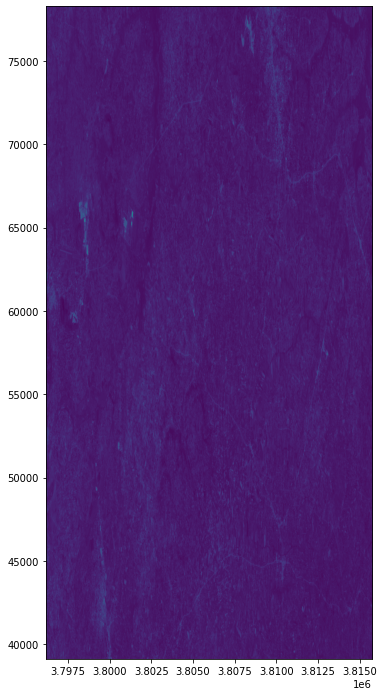

In [29]:
src = rasterio.open(rgb_out_mosaic)

show(src)